[RUN] PSM-I: delta=3, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_3\eps01
[RUN] PSM-I: delta=3, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_3\eps05
[RUN] PSM-I: delta=5, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_5\eps01
[RUN] PSM-I: delta=5, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_5\eps05
[RUN] PSM-I: delta=10, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_10\eps01
[RUN] PSM-I: delta=10, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_10\eps05
[RUN] PSM-I: delta=20, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_20\eps01
[RUN] PSM-I: delta=20, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta\psmi_delta_20\eps05
[RUN] PS

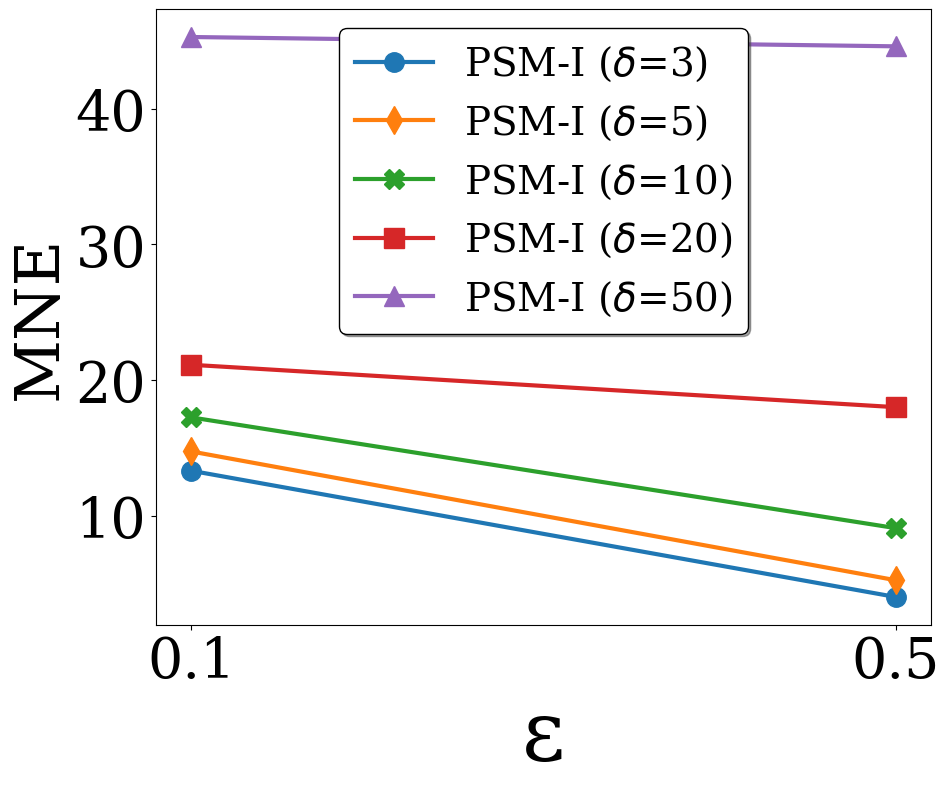

In [2]:
# ============================================================
# PSM-I sweep over (epsilon, delta) ONLY
# - Generates perturbed CSVs for PSM-I under 5 deltas
# - Folder structure:
#   ...\psmi_delta_3\eps01\*.csv
#   ...\psmi_delta_5\eps01\*.csv
#   ...
# - Computes mean distance (MNE) per (delta, epsilon)
# - Plots 5 lines (one per delta) over epsilons [0.1, 0.3, 0.5]
# ============================================================

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from noise_distribution import sample_laplace_radius, sample_psm_radius, sample_psm_radius_bounded
from util import haversine_distance, initial_bearing, destination_point


# ---- Camera-ready settings (avoid Type-3 fonts) ----
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
mpl.rcParams["text.usetex"]  = False
mpl.rcParams["font.family"]  = "serif"


# ============================================================
# 1) Mechanisms (same as yours)
# ============================================================

def planar_laplace_mechanism(lat: float, lon: float, epsilon: float, earth_radius: float = 6_371_000):
    r = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def planar_staircase_mechanism(lat: float, lon: float, epsilon: float, delta: float = 1.0, earth_radius: float = 6_371_000):
    r = sample_psm_radius(epsilon, delta=delta)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius=6_371_000, delta_step=1.0):
    r = sample_psm_radius_bounded(epsilon, L=r_b, delta=delta_step)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def apply_psmi_to_dataframe(
    df,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,
    earth_radius=6_371_000,
    use_noisy_threshold=True
):
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    # threshold sampled once per trajectory
    threshold = float(delta)
    if use_noisy_threshold:
        noise = sample_psm_radius_bounded(epsilon, L=thr_L, delta=delta)
        threshold = float(delta + noise)

    # init
    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])

    y1_lat, y1_lon = bounded_planar_staircase_mechanism(
        x1_lat, x1_lon, epsilon, r_b,
        earth_radius=earth_radius,
        delta_step=delta
    )

    z1_lat, z1_lon = planar_staircase_mechanism(
        y1_lat, y1_lon, epsilon,
        delta=delta,
        earth_radius=earth_radius
    )

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            z_new_lat, z_new_lon = planar_staircase_mechanism(
                y_cur_lat, y_cur_lon, epsilon,
                delta=delta,
                earth_radius=earth_radius
            )
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    distances = haversine_distance(
        df["latitude"].values, df["longitude"].values,
        z_lat, z_lon,
        earth_radius
    )
    return y_lat, y_lon, z_lat, z_lon, distances


def batch_perturb_psmi_csv(
    input_folder,
    output_folder,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,
    use_noisy_threshold=True,
    earth_radius=6_371_000
):
    """
    Perturb all CSVs in input_folder with PSM-I and write to output_folder.
    Output CSVs contain: intermediate_latitude/longitude, perturbed_latitude/longitude, distance
    """
    os.makedirs(output_folder, exist_ok=True)

    for filepath in glob.glob(os.path.join(input_folder, "*.csv")):
        df = pd.read_csv(filepath)

        if not {"latitude", "longitude"}.issubset(df.columns):
            print(f"[WARN] Skipping {filepath}: missing latitude/longitude")
            continue

        y_lat, y_lon, z_lat, z_lon, distances = apply_psmi_to_dataframe(
            df,
            epsilon=epsilon,
            delta=delta,
            r_b=r_b,
            thr_L=thr_L,
            earth_radius=earth_radius,
            use_noisy_threshold=use_noisy_threshold
        )

        df["intermediate_latitude"]  = y_lat
        df["intermediate_longitude"] = y_lon
        df["perturbed_latitude"]     = z_lat
        df["perturbed_longitude"]    = z_lon
        df["distance"]               = distances

        out_path = os.path.join(output_folder, os.path.basename(filepath))
        df.to_csv(out_path, index=False)


# ============================================================
# 2) Utility aggregation + plotting
# ============================================================

def eps_suffix(eps: float) -> str:
    # matches your existing structure: 0.1 -> eps01, 0.3 -> eps03, 0.5 -> eps05
    return f"eps{int(round(eps*10)):02d}" if eps < 1 else f"eps{int(eps)}"


def mean_distance_in_folder(folder: str) -> float:
    if not os.path.isdir(folder):
        print(f"[WARN] Missing folder: {folder}")
        return float("nan")

    files = glob.glob(os.path.join(folder, "*.csv"))
    if not files:
        print(f"[WARN] No CSV files in: {folder}")
        return float("nan")

    per_file_means = []
    for f in files:
        try:
            df = pd.read_csv(f)
            if "distance" not in df.columns:
                print(f"[WARN] 'distance' missing in: {f}")
                continue
            if len(df["distance"]) == 0:
                continue
            per_file_means.append(df["distance"].mean())
        except Exception as e:
            print(f"[WARN] Failed reading {f}: {e}")

    if not per_file_means:
        print(f"[WARN] No valid distance values in: {folder}")
        return float("nan")

    return float(np.mean(per_file_means))


# ============================================================
# 3) MAIN EXPERIMENT
# ============================================================

if __name__ == "__main__":
    # --- you requested fewer epsilons ---
    epsilons = [0.1, 0.5]

    # --- deltas you requested ---
    deltas = [3, 5, 10, 20, 50]

    # --- input (original trajectories) ---
    input_folder = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\original\geotrace\utility"

    # --- output base for delta-sweep runs ---
    # will create:
    #   ...\psmi_delta_3\eps01\*.csv
    #   ...\psmi_delta_5\eps03\*.csv
    # etc.
    out_base = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\delta"

    # --- PSM-I params (keep consistent across sweeps unless you want to change) ---
    r_b = 50.0
    thr_L = 2.0
    use_noisy_threshold = True
    earth_radius = 6_371_000

    # ----------------------------
    # A) Generate perturbed data
    # ----------------------------
    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        for eps in epsilons:
            suffix = eps_suffix(eps)
            out_dir = os.path.join(delta_base_dir, suffix)

            print(f"[RUN] PSM-I: delta={delta}, eps={eps} -> {out_dir}")

            batch_perturb_psmi_csv(
                input_folder=input_folder,
                output_folder=out_dir,
                epsilon=eps,
                delta=float(delta),
                r_b=r_b,
                thr_L=thr_L,
                use_noisy_threshold=use_noisy_threshold,
                earth_radius=earth_radius
            )

    # ----------------------------
    # B) Compute means + print
    # ----------------------------
    means_by_delta = {}  # delta -> list aligned with epsilons

    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        vals = []
        for eps in epsilons:
            suffix = eps_suffix(eps)
            folder = os.path.join(delta_base_dir, suffix)
            vals.append(mean_distance_in_folder(folder))

        means_by_delta[delta] = vals

    print("\n==================== RESULTS (MNE) ====================")
    print("epsilons:", epsilons)
    for delta in deltas:
        print(f"delta={delta:>2} :", means_by_delta[delta])
    print("=======================================================\n")

    # ----------------------------
    # C) Plot (5 lines)
    # ----------------------------
    FIGSIZE = (10, 8)
    plt.figure(figsize=FIGSIZE)

    markers = ["o", "d", "X", "s", "^"]  # 5 lines
    for i, delta in enumerate(deltas):
        plt.plot(
            epsilons,
            means_by_delta[delta],
            label=rf"PSM-I ($\delta$={delta})",
            marker=markers[i],
            linestyle="solid",
            linewidth=3,
            markersize=14
        )

    plt.xlabel("ε", fontsize=60)
    plt.ylabel("MNE", fontsize=45)

    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis="both", which="major", labelsize=40)

    legend = plt.legend(fontsize=28, frameon=True, shadow=True)
    legend.get_frame().set_edgecolor("black")

    # ---- Save as PDF ----
    fig_dir = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
    os.makedirs(fig_dir, exist_ok=True)
    pdf_path = os.path.join(fig_dir, "geotrace_psmi_distance_vs_epsilon_delta_sweep.pdf")
    plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

    plt.show()


[RUN] PSM-I: delta=3, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_3\eps01
[RUN] PSM-I: delta=3, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_3\eps05
[RUN] PSM-I: delta=5, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_5\eps01
[RUN] PSM-I: delta=5, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_5\eps05
[RUN] PSM-I: delta=10, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_10\eps01
[RUN] PSM-I: delta=10, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_10\eps05
[RUN] PSM-I: delta=20, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_20\eps01
[RUN] PSM-I: delta=20, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta\psmi_delta_20\eps05
[RUN] PSM-I: del

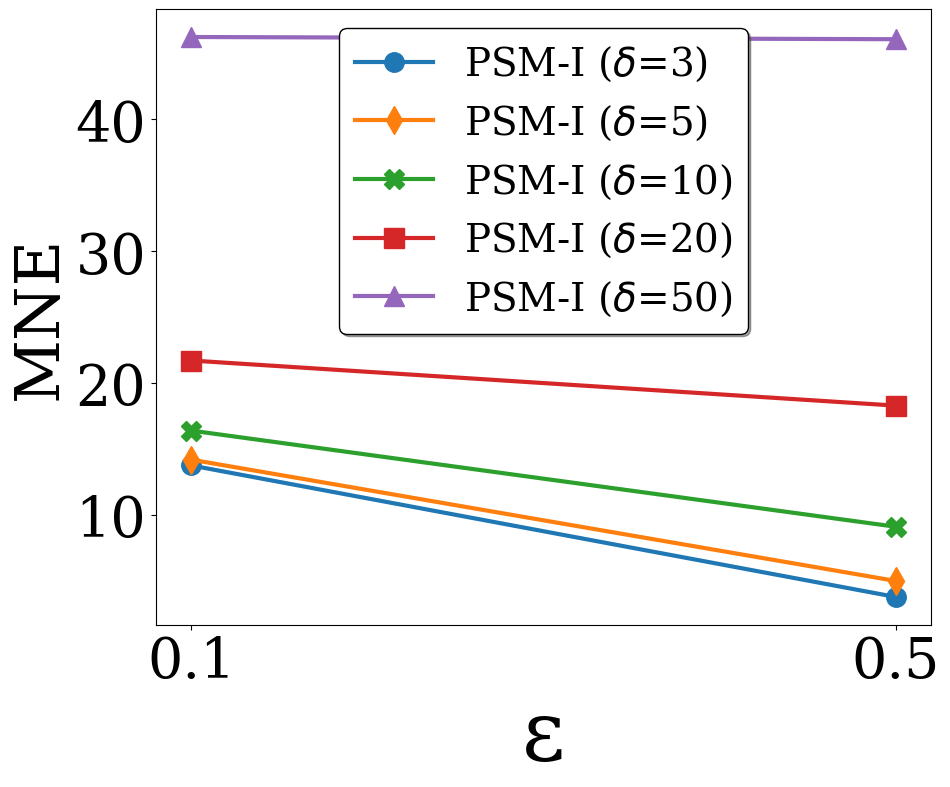

In [3]:
if __name__ == "__main__":
    # --- you requested fewer epsilons ---
    epsilons = [0.1, 0.5]

    # --- deltas you requested ---
    deltas = [3, 5, 10, 20, 50]

    # --- input (original trajectories) ---
    input_folder = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\original\geolife\utility"

    # --- output base for delta-sweep runs ---
    # will create:
    #   ...\psmi_delta_3\eps01\*.csv
    #   ...\psmi_delta_5\eps03\*.csv
    # etc.
    out_base = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geolife\delta"

    # --- PSM-I params (keep consistent across sweeps unless you want to change) ---
    r_b = 50.0
    thr_L = 2.0
    use_noisy_threshold = True
    earth_radius = 6_371_000

    # ----------------------------
    # A) Generate perturbed data
    # ----------------------------
    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        for eps in epsilons:
            suffix = eps_suffix(eps)
            out_dir = os.path.join(delta_base_dir, suffix)

            print(f"[RUN] PSM-I: delta={delta}, eps={eps} -> {out_dir}")

            batch_perturb_psmi_csv(
                input_folder=input_folder,
                output_folder=out_dir,
                epsilon=eps,
                delta=float(delta),
                r_b=r_b,
                thr_L=thr_L,
                use_noisy_threshold=use_noisy_threshold,
                earth_radius=earth_radius
            )

    # ----------------------------
    # B) Compute means + print
    # ----------------------------
    means_by_delta = {}  # delta -> list aligned with epsilons

    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        vals = []
        for eps in epsilons:
            suffix = eps_suffix(eps)
            folder = os.path.join(delta_base_dir, suffix)
            vals.append(mean_distance_in_folder(folder))

        means_by_delta[delta] = vals

    print("\n==================== RESULTS (MNE) ====================")
    print("epsilons:", epsilons)
    for delta in deltas:
        print(f"delta={delta:>2} :", means_by_delta[delta])
    print("=======================================================\n")

    # ----------------------------
    # C) Plot (5 lines)
    # ----------------------------
    FIGSIZE = (10, 8)
    plt.figure(figsize=FIGSIZE)

    markers = ["o", "d", "X", "s", "^"]  # 5 lines
    for i, delta in enumerate(deltas):
        plt.plot(
            epsilons,
            means_by_delta[delta],
            label=rf"PSM-I ($\delta$={delta})",
            marker=markers[i],
            linestyle="solid",
            linewidth=3,
            markersize=14
        )

    plt.xlabel("ε", fontsize=60)
    plt.ylabel("MNE", fontsize=45)

    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis="both", which="major", labelsize=40)

    legend = plt.legend(fontsize=28, frameon=True, shadow=True)
    legend.get_frame().set_edgecolor("black")

    # ---- Save as PDF ----
    fig_dir = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
    os.makedirs(fig_dir, exist_ok=True)
    pdf_path = os.path.join(fig_dir, "geolife_psmi_distance_vs_epsilon_delta_sweep.pdf")
    plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

    plt.show()

[RUN] PSM-I: delta=3, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_3\eps01
[RUN] PSM-I: delta=3, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_3\eps05
[RUN] PSM-I: delta=5, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_5\eps01
[RUN] PSM-I: delta=5, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_5\eps05
[RUN] PSM-I: delta=10, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_10\eps01
[RUN] PSM-I: delta=10, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_10\eps05
[RUN] PSM-I: delta=20, eps=0.1 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_20\eps01
[RUN] PSM-I: delta=20, eps=0.5 -> C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta\psmi_delta_20\eps05
[RUN] PSM-I: delta=50, e

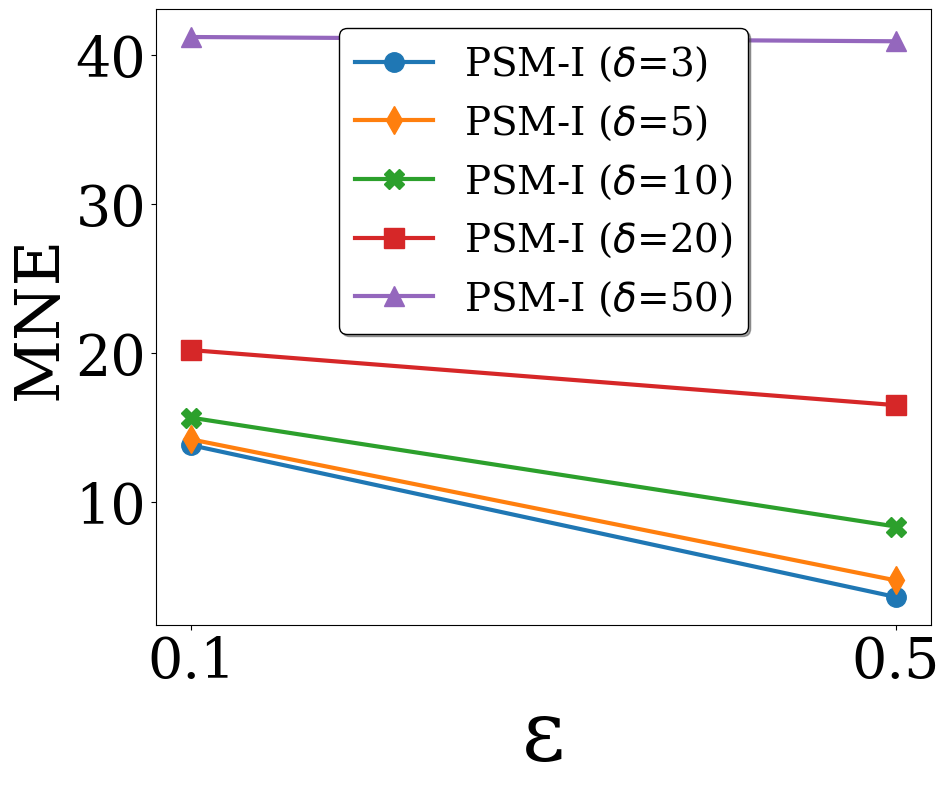

In [4]:
if __name__ == "__main__":
    # --- you requested fewer epsilons ---
    epsilons = [0.1, 0.5]

    # --- deltas you requested ---
    deltas = [3, 5, 10, 20, 50]

    # --- input (original trajectories) ---
    input_folder = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\original\tdrive\utility"

    # --- output base for delta-sweep runs ---
    # will create:
    #   ...\psmi_delta_3\eps01\*.csv
    #   ...\psmi_delta_5\eps03\*.csv
    # etc.
    out_base = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\tdrive\delta"

    # --- PSM-I params (keep consistent across sweeps unless you want to change) ---
    r_b = 50.0
    thr_L = 2.0
    use_noisy_threshold = True
    earth_radius = 6_371_000

    # ----------------------------
    # A) Generate perturbed data
    # ----------------------------
    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        for eps in epsilons:
            suffix = eps_suffix(eps)
            out_dir = os.path.join(delta_base_dir, suffix)

            print(f"[RUN] PSM-I: delta={delta}, eps={eps} -> {out_dir}")

            batch_perturb_psmi_csv(
                input_folder=input_folder,
                output_folder=out_dir,
                epsilon=eps,
                delta=float(delta),
                r_b=r_b,
                thr_L=thr_L,
                use_noisy_threshold=use_noisy_threshold,
                earth_radius=earth_radius
            )

    # ----------------------------
    # B) Compute means + print
    # ----------------------------
    means_by_delta = {}  # delta -> list aligned with epsilons

    for delta in deltas:
        delta_folder_name = f"psmi_delta_{delta}"
        delta_base_dir = os.path.join(out_base, delta_folder_name)

        vals = []
        for eps in epsilons:
            suffix = eps_suffix(eps)
            folder = os.path.join(delta_base_dir, suffix)
            vals.append(mean_distance_in_folder(folder))

        means_by_delta[delta] = vals

    print("\n==================== RESULTS (MNE) ====================")
    print("epsilons:", epsilons)
    for delta in deltas:
        print(f"delta={delta:>2} :", means_by_delta[delta])
    print("=======================================================\n")

    # ----------------------------
    # C) Plot (5 lines)
    # ----------------------------
    FIGSIZE = (10, 8)
    plt.figure(figsize=FIGSIZE)

    markers = ["o", "d", "X", "s", "^"]  # 5 lines
    for i, delta in enumerate(deltas):
        plt.plot(
            epsilons,
            means_by_delta[delta],
            label=rf"PSM-I ($\delta$={delta})",
            marker=markers[i],
            linestyle="solid",
            linewidth=3,
            markersize=14
        )

    plt.xlabel("ε", fontsize=60)
    plt.ylabel("MNE", fontsize=45)

    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis="both", which="major", labelsize=40)

    legend = plt.legend(fontsize=28, frameon=True, shadow=True)
    legend.get_frame().set_edgecolor("black")

    # ---- Save as PDF ----
    fig_dir = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
    os.makedirs(fig_dir, exist_ok=True)
    pdf_path = os.path.join(fig_dir, "tdrive_psmi_distance_vs_epsilon_delta_sweep.pdf")
    plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

    plt.show()